In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    https://github.com/tylersco/deep-neural-networks-art-images
    http://www.scipy-lectures.org/advanced/image_processing/
    
Autoencoder:
576	384	192(bottleneck)	384	576
"""
from scipy import misc
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob
import pandas as pd
import csv
import math
from __future__ import division, print_function, absolute_import
from data.img.ArtDataLoader import ArtData
import Plotter
from Plotter import plot_acc_distance
from Plotter import plot_acc_cosine
from Plotter import plot_prob_distance
from Plotter import plot_prob_cosine
from Plotter import plot_2lists
from Plotter import plot_4lists
from MySpearman import get_distance_prob_correlation
from MySpearman import get_cosine_prob_correlation
from MySpearman import get_distance_acc_correlation
from MySpearman import get_cosine_acc_correlation

from scipy.stats import spearmanr

In [2]:
from scipy import misc
art_data = ArtData()
art_data.load_all_data()
#art_data.load_images()
#art_data.load_metadata()

ArtData Initialized!
2592  images loaded!


In [3]:
#print(art_data.train_images.keys())
#Validate
print(art_data.alpha_pairs['same'][0][95])
print(art_data.beta_pairs['same'][0][95])

print(art_data.alpha_pairs['diff'][0][95])
print(art_data.beta_pairs['diff'][0][95])

2018-impressionist-16x16.jpg
2134-impressionist-16x16.jpg
1233-cubist-16x16.jpg
1185-cubist-16x16.jpg


In [4]:
print(art_data.train_images['0001-cubist-16x16.jpg'].shape)

(16, 16, 3)


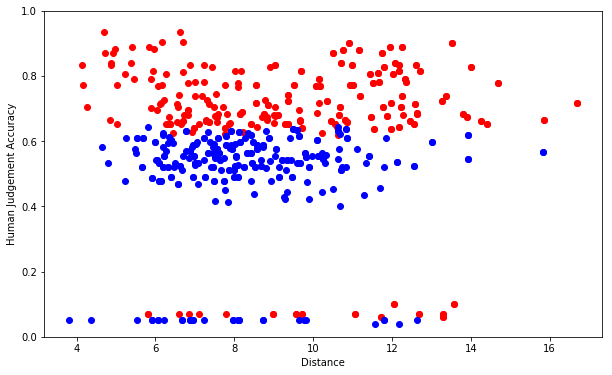

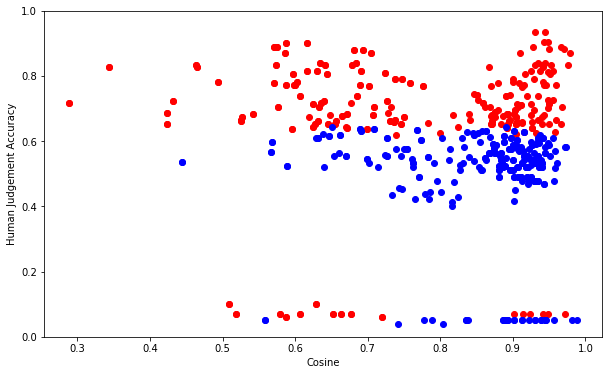

In [5]:
#Raw data - Human Judgement Accuracy
plot_acc_distance(art_data)
plot_acc_cosine(art_data)

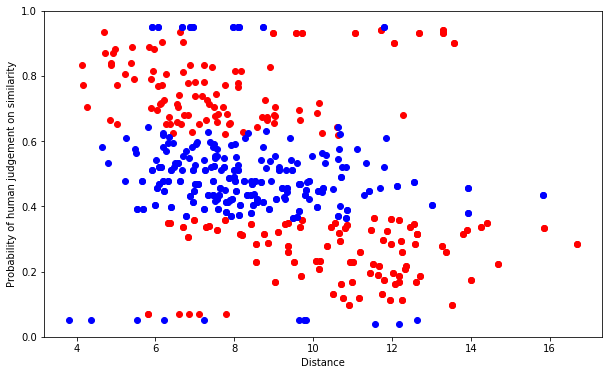

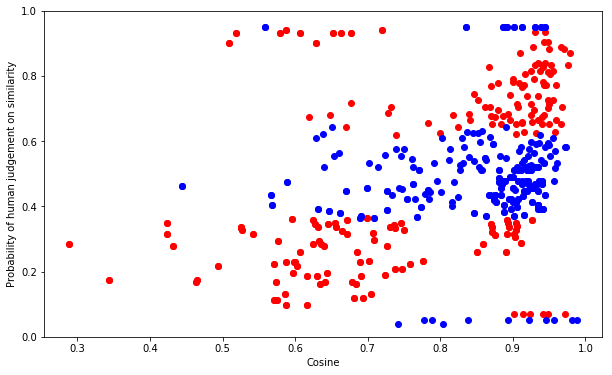

In [6]:
#Raw data - Probability of human judgement on similarity
plot_prob_distance(art_data)
plot_prob_cosine(art_data)

In [7]:
get_distance_prob_correlation(art_data)

SpearmanrResult(correlation=-0.4531196797090763, pvalue=1.6549967874513576e-30)

In [8]:
get_cosine_prob_correlation(art_data)

SpearmanrResult(correlation=0.42701803307779929, pvalue=6.2551843304760119e-27)

In [9]:
get_distance_acc_correlation(art_data)

SpearmanrResult(correlation=0.18460752476813316, pvalue=8.2212500213044036e-06)

In [10]:
get_cosine_acc_correlation(art_data)

SpearmanrResult(correlation=-0.23142047705047938, pvalue=1.9265333564185278e-08)

In [11]:
#start of autoencoder
'''
Reference:
https://github.com/MorvanZhou/tutorials/edit/master/tensorflowTUT/tf21_autoencoder/full_code.py
My tutorial website: https://morvanzhou.github.io/tutorials/
'''
learning_rate = 0.01
training_epochs = 1000
batch_size = 256
display_step = 5
# Network Parameters
n_input = 768 # image data input (img shape: 16*16*3)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

# hidden layer settings
n_hidden_1 = 576
n_hidden_2 = 384
n_hidden_3 = 192

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([n_input])),
}

# Building the encoder
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    return layer_3



# Building the decoder
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    return layer_3

In [12]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
y_bottleneck = encoder_op

# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# Launch the graph
with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    total_batch = int(len(art_data.train_images) / batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = art_data.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
    
    #alpha
    encode_output_alpha_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_output_alpha_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    encode_decode_output_alpha_a = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_decode_output_alpha_b = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    #beta
    encode_output_beta_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_output_beta_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[1]})
    
    encode_decode_output_beta_a = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_decode_output_beta_b = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[1]})
  
encode_outout_alpha_a = encode_output_alpha_a.tolist()
encode_output_alpha_b = encode_output_alpha_b.tolist()

encode_decode_output_alpha_a = encode_decode_output_alpha_a.tolist()
encode_decode_output_alpha_b = encode_decode_output_alpha_b.tolist()

encode_output_beta_a = encode_output_beta_a.tolist()
encode_output_beta_b = encode_output_beta_b.tolist()

encode_decode_output_beta_a = encode_decode_output_beta_a.tolist()
encode_decode_output_beta_b = encode_decode_output_beta_b.tolist()

Epoch: 0001 cost= 0.198190019
Epoch: 0006 cost= 0.135664031
Epoch: 0011 cost= 0.121625803
Epoch: 0016 cost= 0.126437917
Epoch: 0021 cost= 0.122205138
Epoch: 0026 cost= 0.117156148
Epoch: 0031 cost= 0.124810062
Epoch: 0036 cost= 0.117901981
Epoch: 0041 cost= 0.117780954
Epoch: 0046 cost= 0.114610739
Epoch: 0051 cost= 0.115142129
Epoch: 0056 cost= 0.114570200
Epoch: 0061 cost= 0.116851933
Epoch: 0066 cost= 0.109267943
Epoch: 0071 cost= 0.116721936
Epoch: 0076 cost= 0.117428958
Epoch: 0081 cost= 0.114184499
Epoch: 0086 cost= 0.118015885
Epoch: 0091 cost= 0.115958452
Epoch: 0096 cost= 0.116790853
Epoch: 0101 cost= 0.114700168
Epoch: 0106 cost= 0.113605738
Epoch: 0111 cost= 0.114313982
Epoch: 0116 cost= 0.117284887
Epoch: 0121 cost= 0.110974371
Epoch: 0126 cost= 0.117873497
Epoch: 0131 cost= 0.117545903
Epoch: 0136 cost= 0.114736974
Epoch: 0141 cost= 0.118119031
Epoch: 0146 cost= 0.115864165
Epoch: 0151 cost= 0.120559536
Epoch: 0156 cost= 0.115616322
Epoch: 0161 cost= 0.115977921
Epoch: 016

In [13]:
#alpha

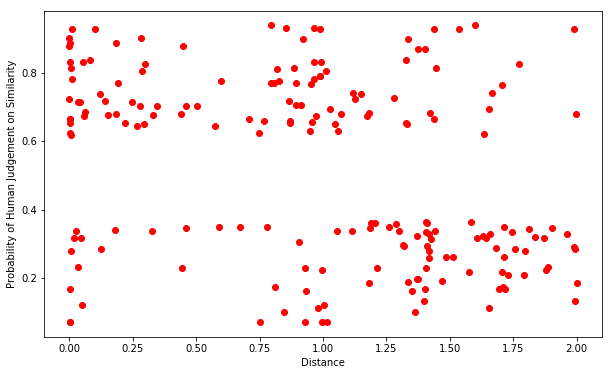

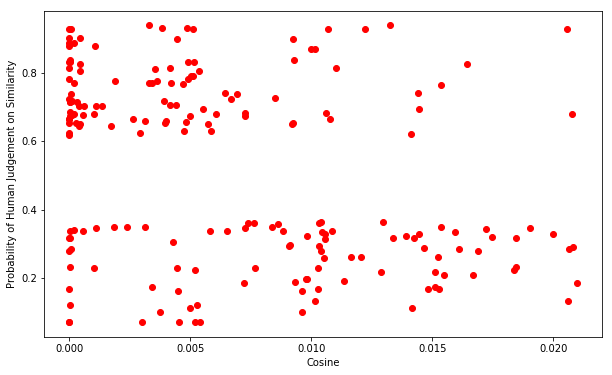

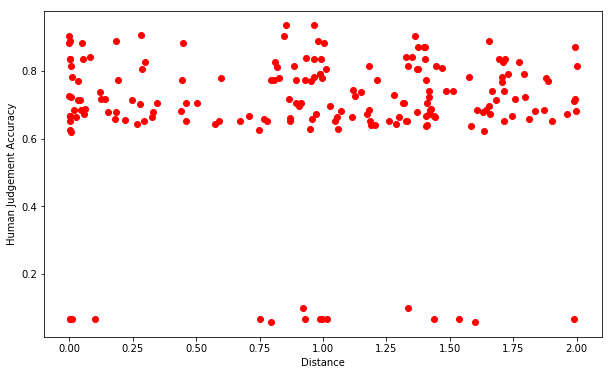

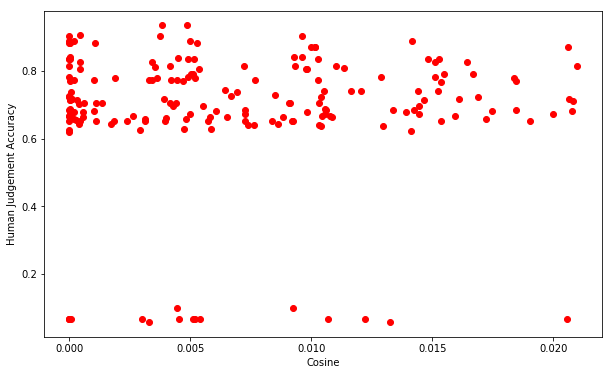

In [14]:
#alpha bottleneck output
#distance, cosine, prob_human_similarity, accuracy
encode_output_alpha_distance = art_data.get_distance_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
encode_output_alpha_cosine = art_data.get_cosine_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
plot_2lists(
    encode_output_alpha_distance, art_data.alpha_prob_human_similarity, 
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_alpha_distance, art_data.alpha_accuracy, 
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_output_alpha_cosine, art_data.alpha_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [15]:
#alpha bottleneck output
#distance, prob_human_similarity
spearmanr(encode_output_alpha_distance, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.31626756096895464, pvalue=7.8598924866121414e-06)

In [16]:
#alpha bottleneck output
#cosine, prob_human_similarity
spearmanr(encode_output_alpha_cosine, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.31339342642406243, pvalue=9.5922283876022082e-06)

In [17]:
#alpha bottleneck output
#distance, accuracy
spearmanr(encode_output_alpha_distance, art_data.alpha_accuracy, axis=None)

SpearmanrResult(correlation=0.01963637849243146, pvalue=0.78689949090942668)

In [18]:
#alpha bottleneck output
#cosine, accuracy
spearmanr(encode_output_alpha_cosine, art_data.alpha_accuracy, axis=None)

SpearmanrResult(correlation=0.019784785585334738, pvalue=0.78532791036635163)

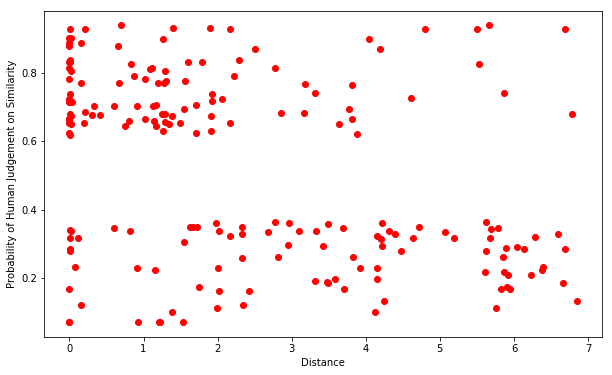

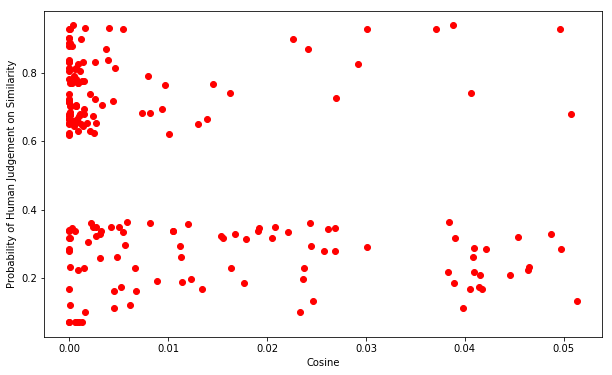

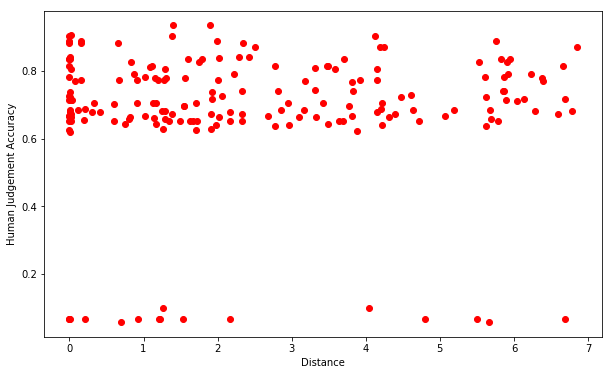

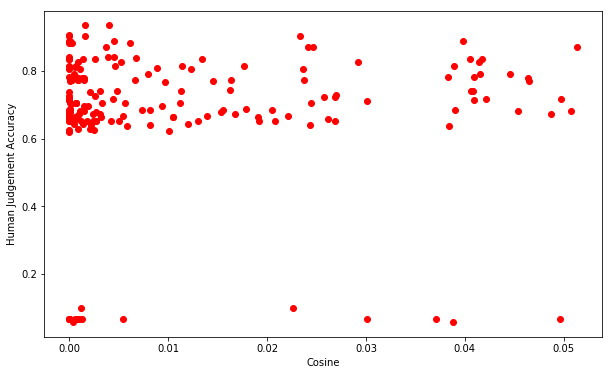

In [19]:
#alpha network output
#distance, cosine, prob_human_similarity, accuracy
encode_decode_output_alpha_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
encode_decode_output_alpha_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
plot_2lists(
    encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity,
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_alpha_distance, art_data.alpha_accuracy,
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_decode_output_alpha_cosine, art_data.alpha_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [20]:
#alpha, network output
#distance, prob_human_similarity
spearmanr(encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.34020257345770105, pvalue=1.3791547371044096e-06)

In [21]:
#alpha, network output
#cosine, prob_human_similarity
spearmanr(encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.34380329599816034, pvalue=1.0478767316065795e-06)

In [22]:
#alpha, network output
#distance, accuracy
spearmanr(encode_decode_output_alpha_distance, art_data.alpha_accuracy, axis=None)

SpearmanrResult(correlation=0.032401084563175503, pvalue=0.65549030936630193)

In [23]:
#alpha, network output
#cosine, accuracy
spearmanr(encode_decode_output_alpha_cosine, art_data.alpha_accuracy, axis=None)

SpearmanrResult(correlation=0.04676434703462061, pvalue=0.51950607069564525)

In [24]:
#beta

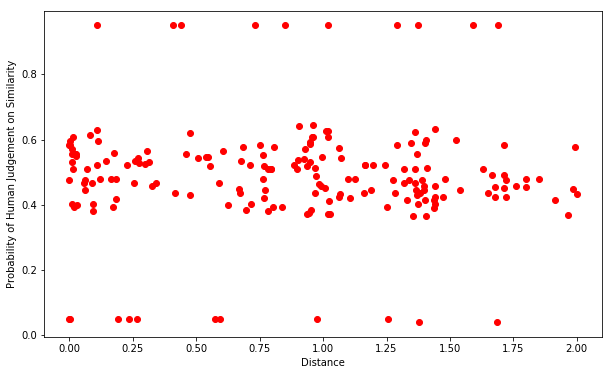

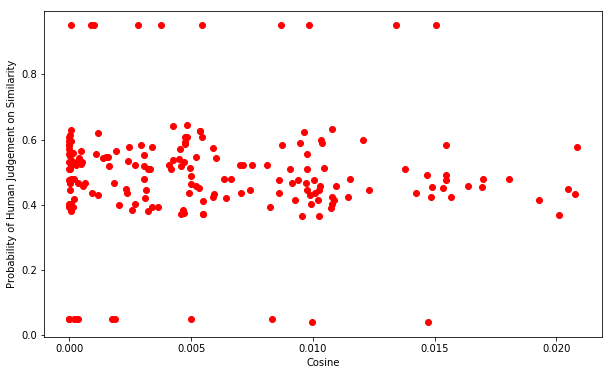

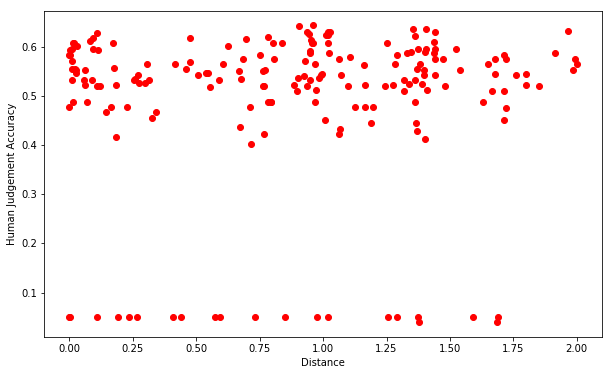

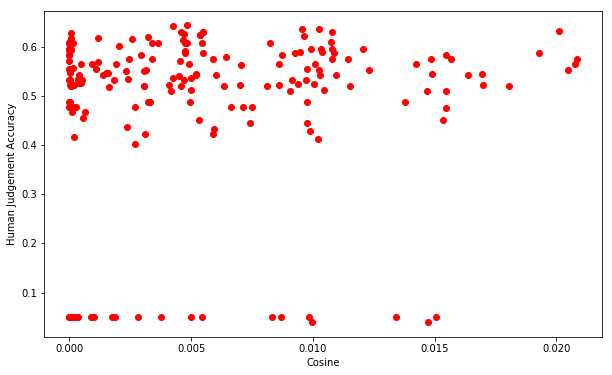

In [25]:
#beta, bottleneck output
#distance, cosine, prob_human_similarity, accuracy
encode_output_beta_distance = art_data.get_distance_list_flatten(encode_output_beta_a, encode_output_beta_b)
encode_output_beta_cosine = art_data.get_cosine_list_flatten(encode_output_beta_a, encode_output_beta_b)
plot_2lists(
    encode_output_beta_distance, art_data.beta_prob_human_similarity,
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_beta_cosine, art_data.beta_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_beta_distance, art_data.beta_accuracy,
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_output_beta_cosine, art_data.beta_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [26]:
#beta, bottleneck output
#distance, prob_human_similarity
spearmanr(encode_output_beta_distance, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.12375654728246853, pvalue=0.087228188449605587)

In [27]:
#beta, bottleneck output
#cosine, prob_human_similarity
spearmanr(encode_output_beta_cosine, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.12314263598309336, pvalue=0.088820101293650353)

In [28]:
#beta, bottleneck output
#distance, accuracy
spearmanr(encode_output_beta_distance, art_data.beta_accuracy, axis=None)

SpearmanrResult(correlation=0.043311994721692462, pvalue=0.55083480908597982)

In [29]:
#beta, bottleneck output
#cosine, accuracy
spearmanr(encode_output_beta_cosine, art_data.beta_accuracy, axis=None)

SpearmanrResult(correlation=0.043104995726274034, pvalue=0.55274213793212756)

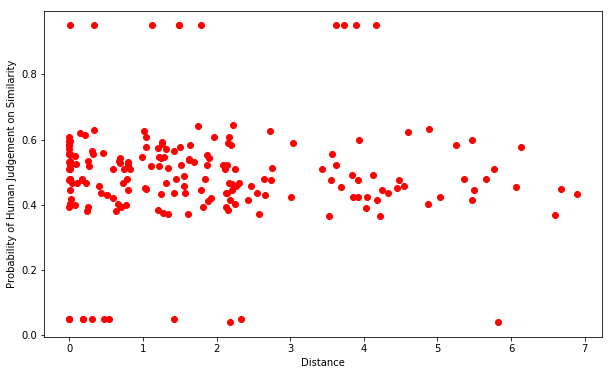

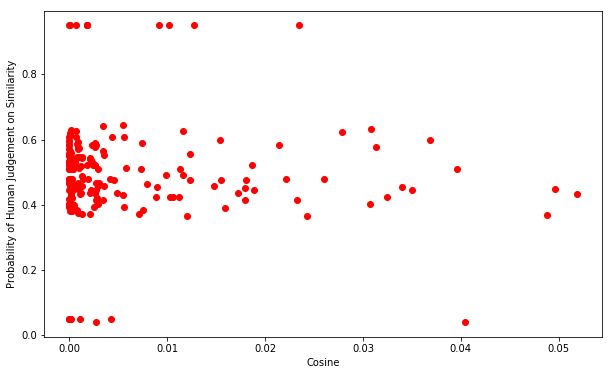

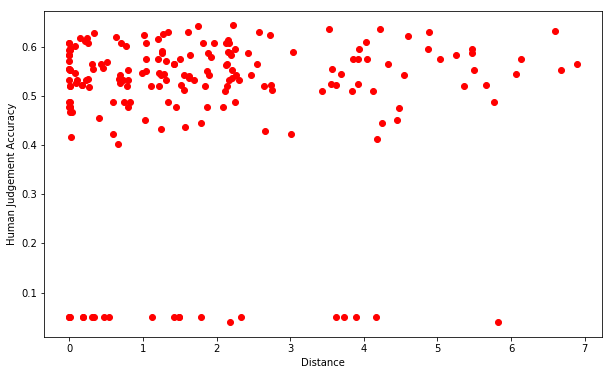

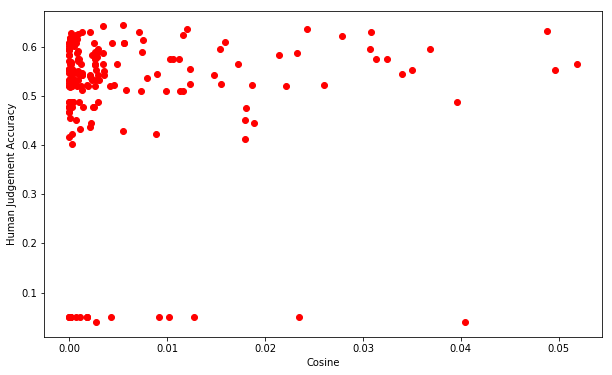

In [30]:
#beta, network output
#distance, cosine, prob_human_similarity, accuracy
encode_decode_output_beta_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
encode_decode_output_beta_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
plot_2lists(
    encode_decode_output_beta_distance, art_data.beta_prob_human_similarity,
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_beta_distance, art_data.beta_accuracy,
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_decode_output_beta_cosine, art_data.beta_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [31]:
#beta, network output
#distance, prob_human_similarity
spearmanr(encode_decode_output_beta_distance, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.082461685017867742, pvalue=0.25549689161498429)

In [32]:
#beta, network output
#cosine, prob_human_similarity
spearmanr(encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.063689905535039587, pvalue=0.38013810803809245)

In [33]:
#beta, network output
#distance, accuracy
spearmanr(encode_decode_output_beta_distance, art_data.beta_accuracy, axis=None)

SpearmanrResult(correlation=0.082753786914291028, pvalue=0.25381133768195796)

In [34]:
#beta, network output
#cosine, accuracy
spearmanr(encode_decode_output_beta_cosine, art_data.beta_accuracy, axis=None)

SpearmanrResult(correlation=0.10985623325295026, pvalue=0.12930018799500931)

In [35]:
#alpha & beta

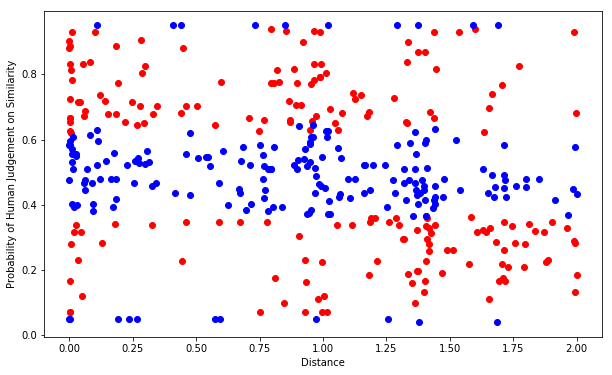

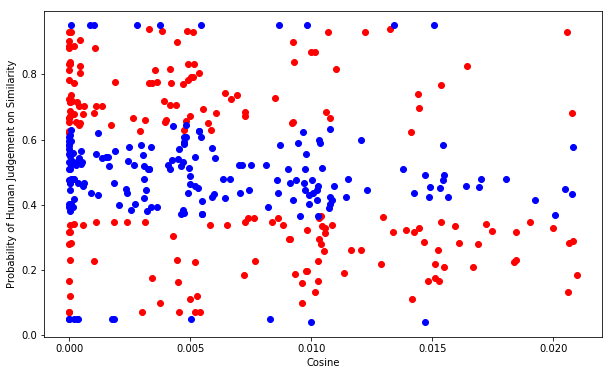

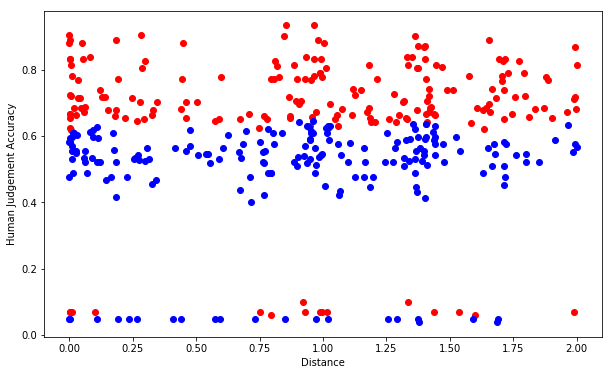

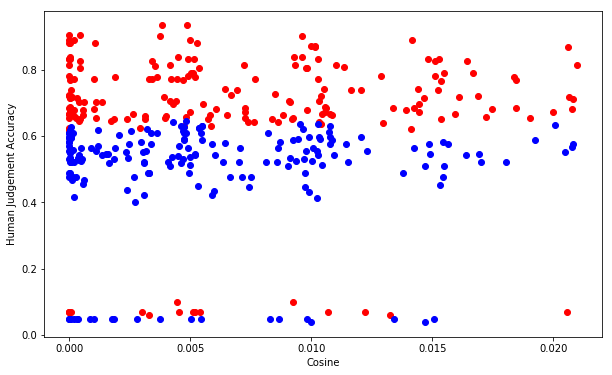

In [36]:
#alpha & beta bottleneck output
#distance, cosine, prob_human_similarity, accuracy
encode_output_distance = []
encode_output_distance.extend(encode_output_alpha_distance)
encode_output_distance.extend(encode_output_beta_distance)

encode_output_cosine = []
encode_output_cosine.extend(encode_output_alpha_cosine)
encode_output_cosine.extend(encode_output_beta_cosine)

prob_human_similarity = []
prob_human_similarity.extend(art_data.alpha_prob_human_similarity)
prob_human_similarity.extend(art_data.beta_prob_human_similarity)

accuracy = []
accuracy.extend(art_data.alpha_accuracy)
accuracy.extend(art_data.alpha_accuracy)

plot_4lists(encode_output_alpha_distance, art_data.alpha_prob_human_similarity,
            encode_output_beta_distance, art_data.beta_prob_human_similarity,
            "Distance", "Probability of Human Judgement on Similarity")
plot_4lists(encode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
            encode_output_beta_cosine, art_data.beta_prob_human_similarity,
            "Cosine", "Probability of Human Judgement on Similarity")

plot_4lists(encode_output_alpha_distance, art_data.alpha_accuracy,
            encode_output_beta_distance, art_data.beta_accuracy,
            "Distance", "Human Judgement Accuracy")
plot_4lists(encode_output_alpha_cosine, art_data.alpha_accuracy,
            encode_output_beta_cosine, art_data.beta_accuracy,
            "Cosine", "Human Judgement Accuracy")

In [37]:
#alpha & beta, bottlenect output
#distance, prob_human_similarity
spearmanr(encode_output_distance, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.2581011202700817, pvalue=2.9223289762728766e-07)

In [38]:
#alpha & beta, bottlenect output
#cosine, prob_human_similarity
spearmanr(encode_output_cosine, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.25667816355146933, pvalue=3.412256116177495e-07)

In [39]:
#alpha & beta, bottlenect output
#distance, accuracy
spearmanr(encode_output_distance, accuracy, axis=None)

SpearmanrResult(correlation=-0.029343387936278071, pvalue=0.56646901018479356)

In [40]:
#alpha & beta, bottlenect output
#cosine, accuracy
spearmanr(encode_output_cosine, accuracy, axis=None)

SpearmanrResult(correlation=-0.029504726006025328, pvalue=0.56433619583847583)

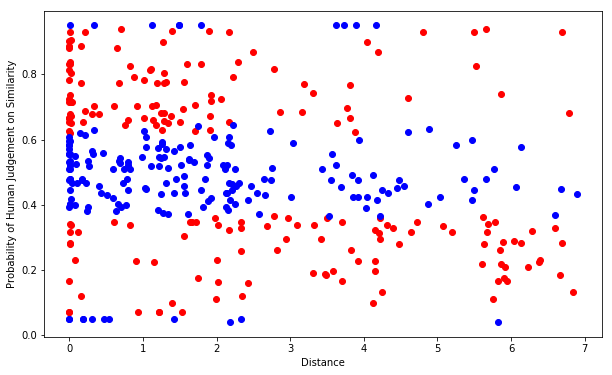

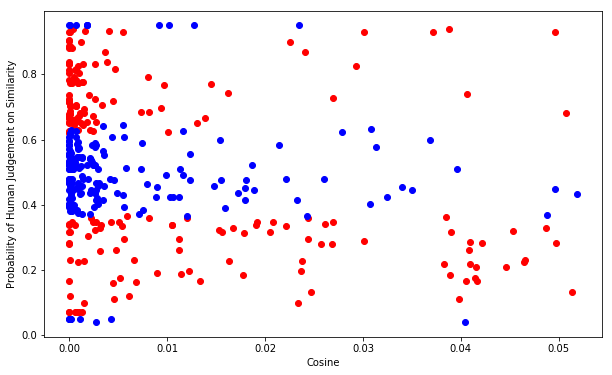

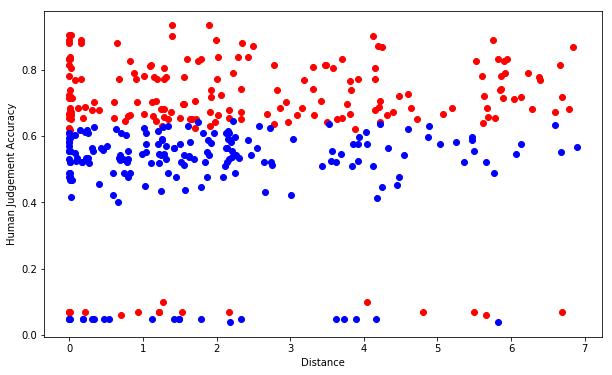

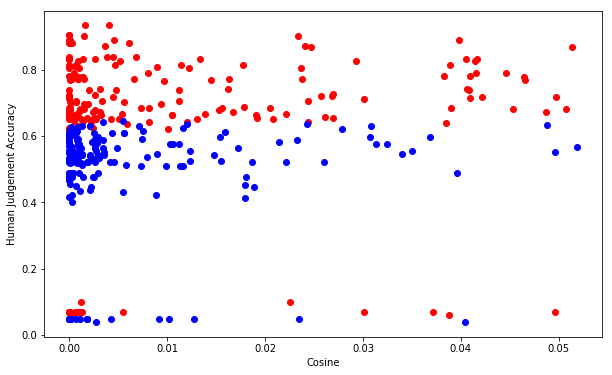

In [41]:
#alpha & beta network output
#distance, cosine, prob_human_similarity, accuracy
encode_decode_output_distance = []
encode_decode_output_distance.extend(encode_decode_output_alpha_distance)
encode_decode_output_distance.extend(encode_decode_output_beta_distance)

encode_decode_output_cosine = []
encode_decode_output_cosine.extend(encode_decode_output_alpha_cosine)
encode_decode_output_cosine.extend(encode_decode_output_beta_cosine)

'''
prob_human_similarity = []
prob_human_similarity.extend(art_data.alpha_prob_human_similarity)
prob_human_similarity.extend(art_data.beta_prob_human_similarity)

accuracy = []
accuracy.extend(art_data.alpha_accuracy)
accuracy.extend(art_data.alpha_accuracy)
'''

plot_4lists(encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity,
            encode_decode_output_beta_distance, art_data.beta_prob_human_similarity,
            "Distance", "Probability of Human Judgement on Similarity")
plot_4lists(encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
            encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity,
            "Cosine", "Probability of Human Judgement on Similarity")

plot_4lists(encode_decode_output_alpha_distance, art_data.alpha_accuracy,
            encode_decode_output_beta_distance, art_data.beta_accuracy,
            "Distance", "Human Judgement Accuracy")
plot_4lists(encode_decode_output_alpha_cosine, art_data.alpha_accuracy,
            encode_decode_output_beta_cosine, art_data.beta_accuracy,
            "Cosine", "Human Judgement Accuracy")

In [42]:
#alpha & beta, network output
#distance, prob_human_similarity
spearmanr(encode_decode_output_distance, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.26494483421120657, pvalue=1.3689151118937113e-07)

In [43]:
#alpha & beta, network output
#cosine, prob_human_similarity
spearmanr(encode_decode_output_cosine, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.26540113832427958, pvalue=1.3004232580135379e-07)

In [44]:
#alpha & beta, network output
#distance, accuracy
spearmanr(encode_decode_output_distance, accuracy, axis=None)

SpearmanrResult(correlation=-0.01828589993925105, pvalue=0.72094906550707272)

In [45]:
#alpha & beta, network output
#cosine, accuracy
spearmanr(encode_decode_output_cosine, accuracy, axis=None)

SpearmanrResult(correlation=-0.002460140553675542, pvalue=0.96167510318561722)